# imports

In [1]:
import uproot4
import uproot
import awkward1 as ak
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
import os,sys
import pandas as pd
from scipy.stats import halfnorm
from coffea import hist

# file I/O

In [2]:
# sim data

Brem003 = "../electrons/sim_eval_Brem_0.033428_z500_600_eps_-5.2.root"
truth003 = uproot.open(Brem003)["Truth"]

Brem047 = "../electrons/sim_eval_Brem_0.470915_z500_600_eps_-6.root"
truth047 = uproot.open(Brem047)["Truth"]

Eta001 = "../electrons/sim_eval_Eta_0.019564_z500_600_eps_-5.2.root"
truth001 = uproot.open(Eta001)["Truth"]

Eta054 = "../electrons/sim_eval_Eta_0.540000_z500_600_eps_-6.root"
truth054 = uproot.open(Eta054)["Truth"]

# testing

## sim data

In [3]:
def get_data_sim(root1):
    
    (root1.array("hit_detID").flatten() >= 1).any()
    masks1 = {}
    
    # mask by hit detID
    detID1 = root1.array("hit_detID").flatten()
    
    # mask by z pos of detector
    truthz1 = root1.array("hit_truthz").flatten()
    
    # hodos
    masks1["H1BT"] = np.logical_and(detID1 >= 31, detID1 <= 32)
    masks1["H2BT"] = np.logical_and(detID1 >= 37, detID1 <= 38)
    masks1["H4BT"] = np.logical_and(detID1 >= 45, detID1 <= 46)
    masks1["H1LR"] = np.logical_and(detID1 >= 33, detID1 <= 34)
    masks1["H2LR"] = np.logical_and(detID1 >= 35, detID1 <= 36)
    masks1["H4Y1LR"] = np.logical_and(detID1 >= 41, detID1 <= 42)
    masks1["H4Y2LR"] = np.logical_and(detID1 >= 43, detID1 <= 44)
    
    # stations
    masks1["st1"] = np.logical_and(truthz1 > 500, truthz1 < 1000)
    masks1["st2"] = np.logical_and(truthz1 > 1200, truthz1 < 1600)
    masks1["st4"] = truthz1 > 2000
    
    det_st = [('H1BT', 'st1'),
              ('H2BT', 'st2'),
              ('H4BT', 'st4'),
              ('H1LR', 'st1'),
              ('H2LR', 'st2'),
              ('H4Y1LR', 'st4'),
              ('H4Y2LR', 'st4')]
    
    # geometry, can safely ignore z pos for now
    vs = [("xy","hit_truthy:hit_truthx","x [cm];y [cm]"),
          ("z","hit_truthz","z [cm]"),]
    
    xs = []
    
    # now implement all the masks, plotting each of the variables in det_pairs
    for det, st in det_st:
        for vshort, var, vtitle in vs:
            mask1 = np.logical_and(masks1[det],masks1[st])
            
            ivars1 = [root1.array(v).flatten() for v in var.split(":")]
            ilabs = vtitle.split(';')

            if (len(ivars1)>1):
                # stacking the data
                if (det[-1]=='T'):
                    x = ivars1[0][mask1]
                else:
                    x = ivars1[1][mask1]
                    
                xs.append(x)
                
    return xs

## cut data

Impose cuts on the data to determine hit correlation. This means:

* Require that an event has at least one hit within some x-range in H_BT
* If the event meets the selection criteria, it is flagged as valid 

These cuts can be chained together, such that you can require hits in three detectors before the event is considered valid. 

The `make_cut` method searches a given event for valid hits in a certain x-range within the desired station (1,2, or 4).

The `get_cut` method imposes the cuts when trying to get the data. It works by looping through all 10,000 events in the simulated data and getting the indices of each valid event meeting the passed criteria using `make_cut`. If multiple detectors are used to produce the cut (i.e. require hits in `x = [-15, 15cm]` in `H1B/T` and hits in `x = [-5, 5cm]` in `H2BT`), then the algorithm loops over all 10,000 events looking for events meeting station 1 criteria before looping over only those valid events to look for events which then *also* satisfy the station 2 criteria. 

**Something in one of/both of these methods is bugged** - see plots @ bottom

In [4]:
def make_cut(branches, event, station=1, pos1=-15, pos2=15):
    '''
    pass a dict of the branches of the ROOT file, and event number 
    make a cut at a given station and x-range (inclusive) for a single event
    returns True or False if the event meets selection criteria
    '''
    flag = False
    
    detIDs = branches['hit_detID'][event]     # detID of each hit in the event
    truthz = branches['hit_truthz'][event]    # z-pos of each hit in the event
    truthx = branches['hit_truthx'][event]    # x-pos of each hit in the event
    validx = np.logical_and(truthx >= pos1, truthx <= pos2)  # valid x-pos given range
    
    if (station==1):   # H1BT
        det = np.logical_and(detIDs >= 31, detIDs <= 32)   # mask by detID of H1BT
        st1 = np.logical_and(truthz > 500, truthz < 1000)  # mask by st1 z-pos criteria
        
        # intersection of the two (det & st) for this event
        det_st_mask = np.logical_and(det,st1)
        
        # now we look at all of the truthx hits, and see if any x-hits meet the criteria
        final_mask = np.logical_and(det_st_mask,validx)

        # check the truthx array for valid hits
        if (len(truthx[final_mask]) != 0):
            flag = True
            
    if (station==2):   # H2BT
        det = np.logical_and(detIDs >= 37, detIDs <= 38)
        st2 = np.logical_and(truthz > 1200, truthz < 1600)
        det_st_mask = np.logical_and(det,st2)
        final_mask = np.logical_and(det_st_mask,validx)
        if (len(truthx[final_mask]) != 0):
            flag = True
            
    if (station==4):   # H4BT
        det = np.logical_and(detIDs >= 45, detIDs <= 46)
        st4 = (truthz > 2000)
        det_st_mask = np.logical_and(det,st4)
        final_mask = np.logical_and(det_st_mask,validx)
        if (len(truthx[final_mask]) != 0):
            flag = True
    
    return flag

In [5]:
def get_cut(root, layer=1, pos1=-15, pos2=15, pos3=-15, pos4=15, pos5=-15, pos6=15):
    '''
    layer specifies up to which layer we are cutting on (1,2,4) -- 3=EMCAL
    pos1, pos2 are for station 1 cut
    pos3, pos4 are for station 2 cut
    '''
    totalEvents = len(root)
    branches = root.arrays(namedecode='utf-8')   # dict of branches, all items are numpy arrays
    
    # all 10,000 events. Pass the boolean final_mask returned from make_cuts to get valid event IDs
    eventID = branches["eventID"]
    
    if (layer == 1):
        indices = np.array([])
        for ID in eventID:   # loop thru all 10,000 events
            if make_cut(branches,ID,station=1,pos1=pos1,pos2=pos2):
                # the event meets the criteria
                indices = np.append(indices,True)
            else:
                # the event does not meet the criteria
                indices = np.append(indices,False)
    
    elif (layer == 2):
        indices = np.array([])
        for ID in eventID:   # loop thru all 10,000 events
            if make_cut(branches,ID,station=1,pos1=pos1,pos2=pos2):
                # the event meets the criteria
                indices = np.append(indices,True)
            else:
                # the event does not meet the criteria
                indices = np.append(indices,False)
        # now we have the indices of valid events meeting station 1 criteria, let's get their eventID
        eventID_st2 = eventID[indices.astype(bool)]
        # now we loop through these valid events
        for ID in eventID_st2:
            if make_cut(branches,ID,station=2,pos1=pos3,pos2=pos4):
                # the event that meets st1 criteria also meets st2 criteria
                indices[ID] = True
            else:
                indices[ID] = False
        # by now, indices array should be updated to meet both criteria
        
    elif (layer == 4):
        indices = np.array([])
        for ID in eventID:   # loop thru all 10,000 events
            if make_cut(branches,ID,station=1,pos1=pos1,pos2=pos2):
                # the event meets the criteria
                indices = np.append(indices,True)
            else:
                # the event does not meet the criteria
                indices = np.append(indices,False)
        
        print("length of indices array {}".format(len(indices)))
        
        eventID_st2 = eventID[indices.astype(bool)]
        for ID in eventID_st2:
            if make_cut(branches,ID,station=2,pos1=pos3,pos2=pos4):
                # the event that meets st1 criteria also meets st2 criteria
                indices[ID] = True
            else:
                indices[ID] = False
        
        print("length of indices array {}".format(len(indices)))
        
        # perform the final cut at station 4
        eventID_st4 = eventID[indices.astype(bool)]
        for ID in eventID_st4:
            if make_cut(branches,ID,station=4,pos1=pos5,pos2=pos6):
                indices[ID] = True
            else:
                indices[ID] = False
                
    # convert the indices array to booleans
    indices = indices.astype(bool)
    
    '''
    with the boolean array of valid event indices, we can make new arrays w the data
    then we can simply follow the original plotting method using the new arrays of valid data
    '''
    # get all the relevant data - 10,000 simulated events
    all_detIDs = branches["hit_detID"]
    all_truthz = branches["hit_truthz"]
    all_truthx = branches["hit_truthx"]
    all_truthy = branches["hit_truthy"]
    
    # select for only valid events -> apply boolean indices mask to all data
    val_detIDs = all_detIDs[indices]
    val_truthz = all_truthz[indices]
    val_truthx = all_truthx[indices]
    val_truthy = all_truthy[indices]
    #debug - the resulting array should be as long as the sum of the Trues in indices
    assert(len(val_detIDs)==np.sum(indices))
    
    # flatten
    detIDs = val_detIDs.flatten()
    truthz = val_truthz.flatten()
    truthx = val_truthx.flatten()
    truthy = val_truthy.flatten()   
    
    
    '''Now we can apply the original technique to get the data'''
    masks = {}
    masks["H1BT"] = np.logical_and(detIDs >= 31, detIDs <= 32)
    masks["H2BT"] = np.logical_and(detIDs >= 37, detIDs <= 38)
    masks["H4BT"] = np.logical_and(detIDs >= 45, detIDs <= 46)
    masks["H1LR"] = np.logical_and(detIDs >= 33, detIDs <= 34)
    masks["H2LR"] = np.logical_and(detIDs >= 35, detIDs <= 36)
    masks["H4Y1LR"] = np.logical_and(detIDs >= 41, detIDs <= 42)
    masks["H4Y2LR"] = np.logical_and(detIDs >= 43, detIDs <= 44)
    masks["st1"] = np.logical_and(truthz > 500, truthz < 1000)
    masks["st2"] = np.logical_and(truthz > 1200, truthz < 1600)
    masks["st4"] = truthz > 2000
    
    
    det_st = [('H1BT', 'st1'),
              ('H2BT', 'st2'),
              ('H4BT', 'st4'),
              ('H1LR', 'st1'),
              ('H2LR', 'st2'),
              ('H4Y1LR', 'st4'),
              ('H4Y2LR', 'st4')]

    vs = [("xy","x [cm];y [cm]")]
    ivars = [truthx, truthy]
    xs = []

    for det, st in det_st:
        for vshort, vtitle in vs:
            detmask = np.logical_and(masks[det],masks[st])
            ilabs = vtitle.split(';')
            if (det[-1]=='T'):
                x = ivars[0][detmask]
            else:
                x = ivars[1][detmask]
            
            xs.append(x)
            
    return xs

## overlay

In [11]:
def combine_data(root, name, layer=1, pos1=-15, pos2=15, pos3=-15, pos4=15, pos5=-15, pos6=15):
    process = name.split("_")[2]
    mass = name.split("_")[3] + "MeV"
    
    bins_range = [(46, (-162.008,162.008), "H1BT"),
                  (32, (-203.38,203.38), "H2BT"),
                  (32, (-304.518,304.518), "H4BT"),
                  (40, (-140.117,140.117), "H1LR"),
                  (38, (-241.285,241.285), "H2LR"),
                  (32, (-365.797,365.797), "H4Y1LR"),
                  (32, (-365.797,365.797), "H4Y2LR")]
    
    # get data
    og = get_data_sim(root)
    cut = get_cut(root,layer,pos1,pos2,pos3,pos4,pos5,pos6)
    
    for i in range(len(bins_range)):
        savename = "cut_and_sim_{}".format(bins_range[i][2])
        title = "Total Hits in {} ({})".format(bins_range[i][2],process)
        plt.clf()
        fig = plt.figure()
        
        '''plot og data'''
        ws_og = np.ones_like(og[i])/10000
        if (i==2) or (i==5) or (i==6):
            ws_og /= 2
        plt.hist(og[i],bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="uncut")
    
        '''plot cut data'''
        ws_cut = np.ones_like(cut[i])/10000
        if (i==2) or (i==5) or (i==6):
            ws_cut /= 2
        l = "layer {} cut".format(layer)
        plt.hist(cut[i],bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label=l)
        
        '''labeling'''
        plt.ylabel("Total Hits")
        if (i<4):
            plt.xlabel("x [cm]")
        else:
            plt.xlabel("y [cm]")
        plt.title(title)
        plt.legend(prop={'size':10})
        #plt.savefig(savename)
        plt.show()

## plotting

This plot is intended to compare the original signal data against data where cuts have been imposed. 

Since we are looking only at the total number of hits which meet the criteria for both the original and the cut, I would expect an amount of hits in the cut data less than or equal to the amount of hits in the uncut data. This is not the case::

<ipython-input-4-1f57026124b5>:12: RuntimeWarning: invalid value encountered in greater_equal
  validx = np.logical_and(truthx >= pos1, truthx <= pos2)  # valid x-pos given range
<ipython-input-4-1f57026124b5>:12: RuntimeWarning: invalid value encountered in less_equal
  validx = np.logical_and(truthx >= pos1, truthx <= pos2)  # valid x-pos given range


<Figure size 432x288 with 0 Axes>

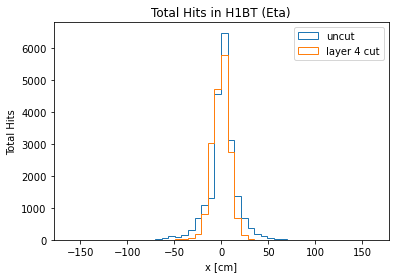

<Figure size 432x288 with 0 Axes>

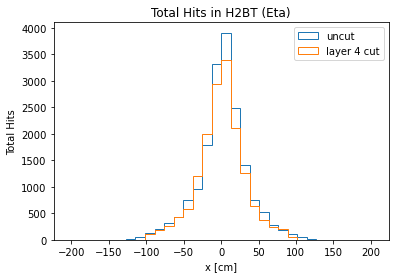

<Figure size 432x288 with 0 Axes>

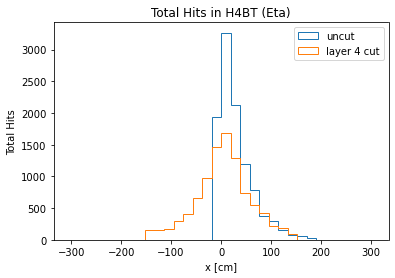

/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 432x288 with 0 Axes>

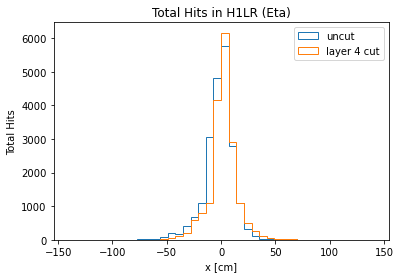

<Figure size 432x288 with 0 Axes>

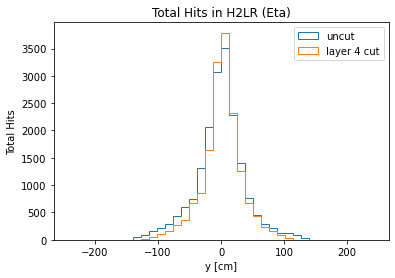

/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 432x288 with 0 Axes>

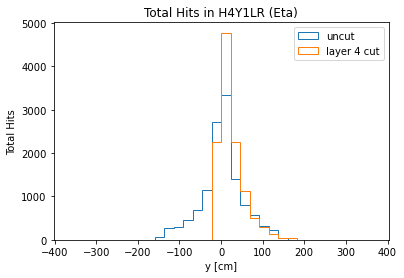

<Figure size 432x288 with 0 Axes>

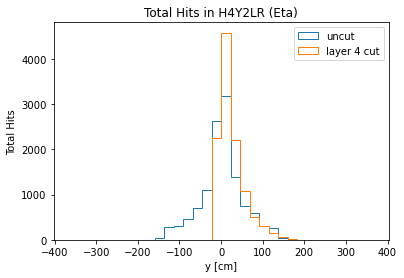

In [12]:
combine_data(truth054,Eta054,layer=4,pos1=-5,pos2=5,pos3=-5,pos4=5,pos5=-5,pos6=5)